In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as font_manager
from mpl_toolkits.mplot3d import axes3d

mpl.rcParams['font.family']='serif'
cmfont = font_manager.FontProperties(fname=mpl.get_data_path() + '/fonts/ttf/cmr10.ttf')
mpl.rcParams['font.serif']=cmfont.get_name()
mpl.rcParams['mathtext.fontset']='cm'
mpl.rcParams['axes.unicode_minus']=False
mpl.rcParams['figure.dpi'] = 300
plt.rcParams["figure.figsize"] = (6,6)
plt.rcParams.update({'font.size': 18})

In [4]:
from sample_3d_view import sample_sphere, sample_torus, visualize_grid_sphere, visualize_grid_torus, sample_ellipsoid

In [5]:
from local_pca_utils import make_nearest_neighbors_graph, make_tangents, make_2nd_order_laplacian,make_general_order_laplacian, make_connection

from curvature_utils import make_tangents_and_normals, get_second_fundamental_form

from tensorlaplacian_utils import get_riemannian_ricci_scalar, get_weitzenbock_operator, get_eigvals_of_weitzenbock, weitzenbock_to_bsr

In [6]:
npoints = 5000

In [7]:
data_s2 = sample_torus(npoints,3,1)
#data_s2 *= 10
s2_graph = make_nearest_neighbors_graph(data_s2, 20, n=npoints)
#s2_tangents, s2_normals, local_coords, s2triu, s2_h = get_second_fundamental_form(data_s2, s2_graph, 2)
_,_,_,_, s2_h = get_second_fundamental_form(data_s2, s2_graph, 2)

Riem, Ric, Scal = get_riemannian_ricci_scalar(s2_h)


100%|██████████| 5000/5000 [00:01<00:00, 3647.21it/s]


In [8]:
weitzenbock = get_weitzenbock_operator(Riem,2,1)
block_weitzenbock = weitzenbock_to_bsr(weitzenbock)

In [9]:
block_weitzenbock

<10000x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 20000 stored elements (blocksize = 2x2) in Block Sparse Row format>

In [10]:
tangents = make_tangents(data_s2, s2_graph, 2)

connection = make_connection(tangents, s2_graph)

s_1st_order_lap = make_general_order_laplacian(connection, s2_graph, 1, sym=False, zero_trace=False)

s_2nd_order_lap = make_2nd_order_laplacian(connection, s2_graph, sym=False, zero_trace=False)

100%|██████████| 5000/5000 [00:05<00:00, 974.45it/s] 


In [11]:
lichnerowicz_yano = -s_1st_order_lap - block_weitzenbock

In [74]:
eigvals, eigvecs = scipy.sparse.linalg.eigsh(lichnerowicz_yano, k=20, which='SM')

In [75]:
eigvals

array([-0.34309423, -0.34309423, -0.33541019, -0.33541019, -0.29986145,
       -0.29986145, -0.27657702, -0.27657702, -0.27378053, -0.27378053,
       -0.07570725, -0.07570725, -0.06549707, -0.06549707,  0.05783694,
        0.05783694,  0.06350566,  0.06350566,  0.10663197,  0.10663197])

In [76]:
eigvecs.shape

(10000, 20)

In [77]:
eigvecs[:,2].shape

(10000,)

In [132]:
eigvector = eigvecs[:,14]

In [133]:
eigvector

array([-0.00178374,  0.00878124, -0.00239591, ...,  0.00980401,
       -0.00310307, -0.01339645])

In [134]:
eigvector = eigvector.reshape(-1,2)

In [135]:
eigvector

array([[-0.00178374,  0.00878124],
       [-0.00239591,  0.00049721],
       [-0.00542307,  0.01335835],
       ...,
       [-0.00011457, -0.01460946],
       [-0.01029072,  0.00980401],
       [-0.00310307, -0.01339645]])

In [136]:
tangents.shape

(5000, 2, 3)

In [137]:
eigvector.shape

(5000, 2)

In [138]:
killingfield = np.zeros((npoints, 3))

In [139]:
for i in range(npoints):
    killingfield[i] = tangents[i, 0]* eigvector[i, 0] +  tangents[i, 1]* eigvector[i, 1] 

In [140]:
killingfield.shape

(5000, 3)

In [141]:
visualizer = np.zeros((npoints, 6))

In [142]:
data_s2.shape

(5000, 3)

In [143]:
indices = np.where(np.logical_not((data_s2[:,0]<0)&(data_s2[:,1]>0)))

In [144]:
indices

(array([   1,    2,    3, ..., 4991, 4994, 4997]),)

In [145]:
visualizer[:,:3] = data_s2
visualizer[:,3:] = killingfield*65

In [146]:
X, Y, Z, U, V, W = zip(*visualizer[:600])

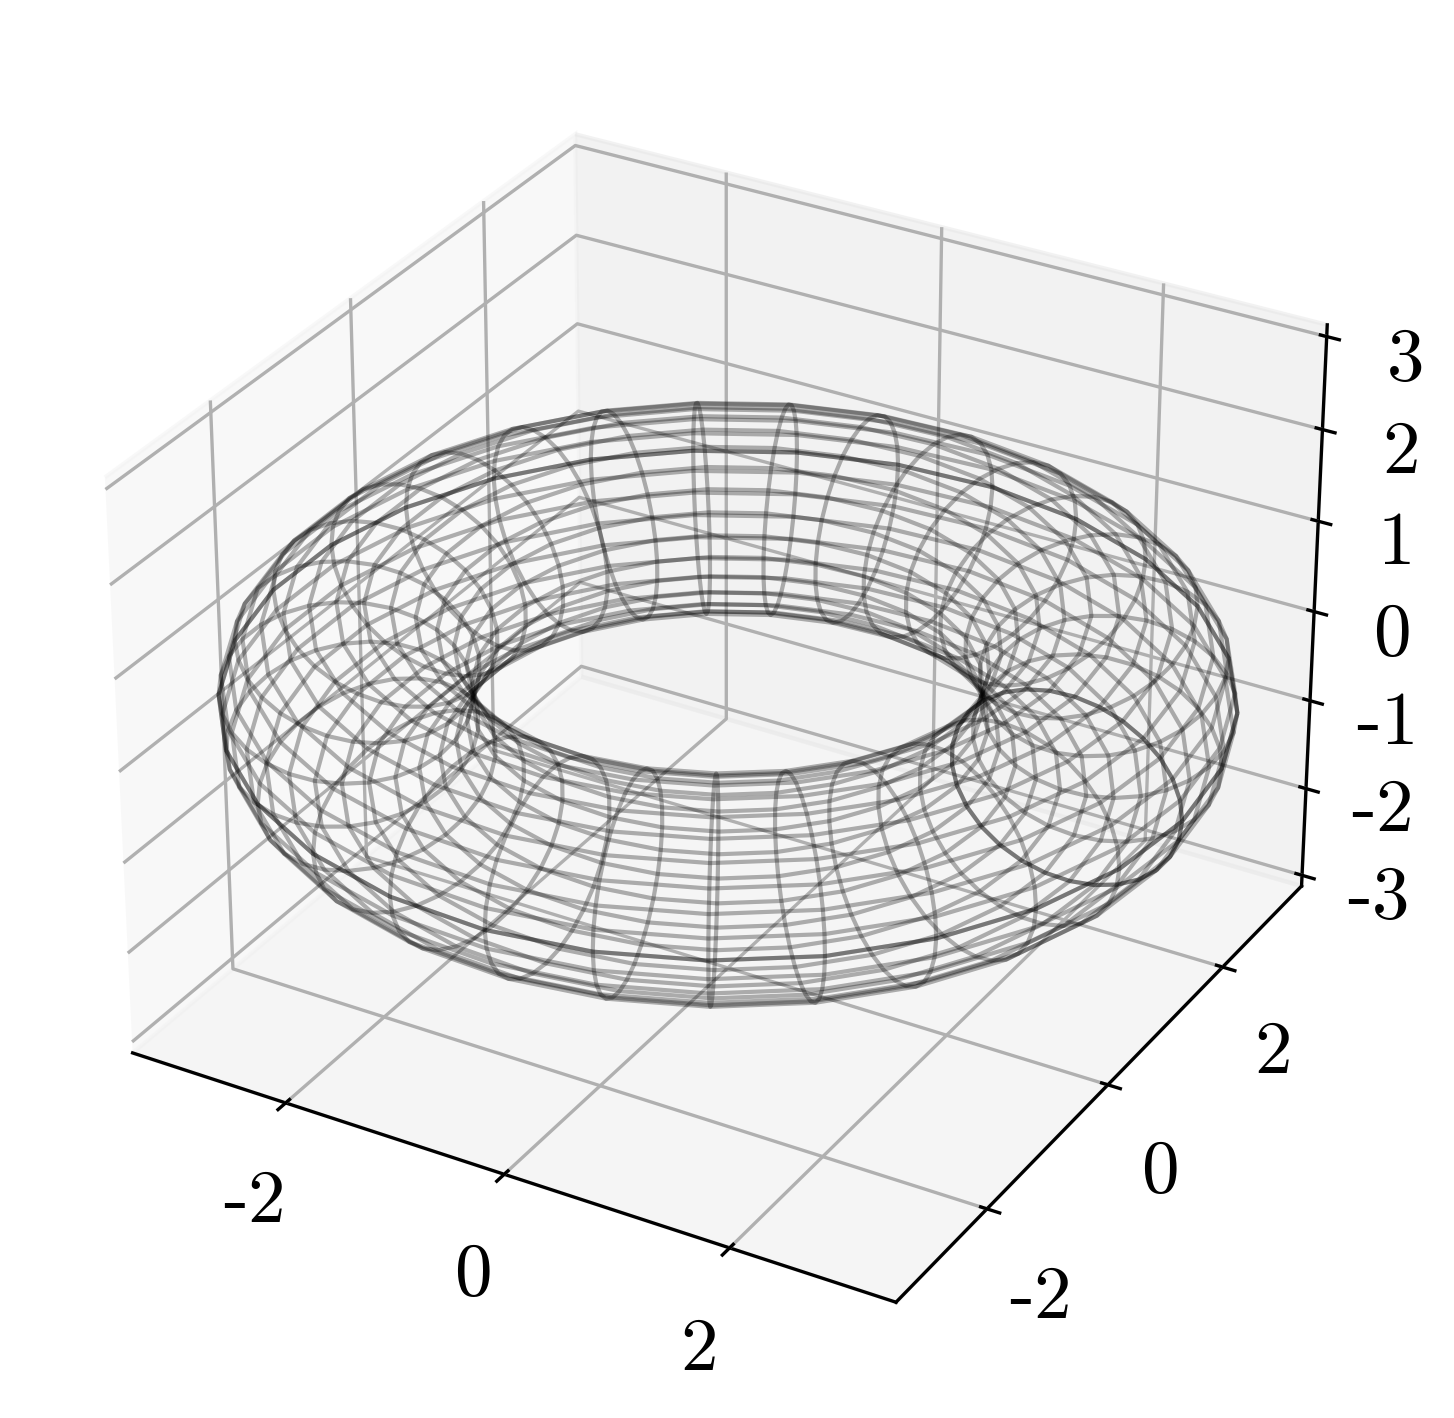

In [147]:
fig, ax = fig, ax = visualize_grid_torus(30,3,1)

In [148]:
ax.quiver(X, Y, Z, U, V, W, color="C0", linewidth=0.6)

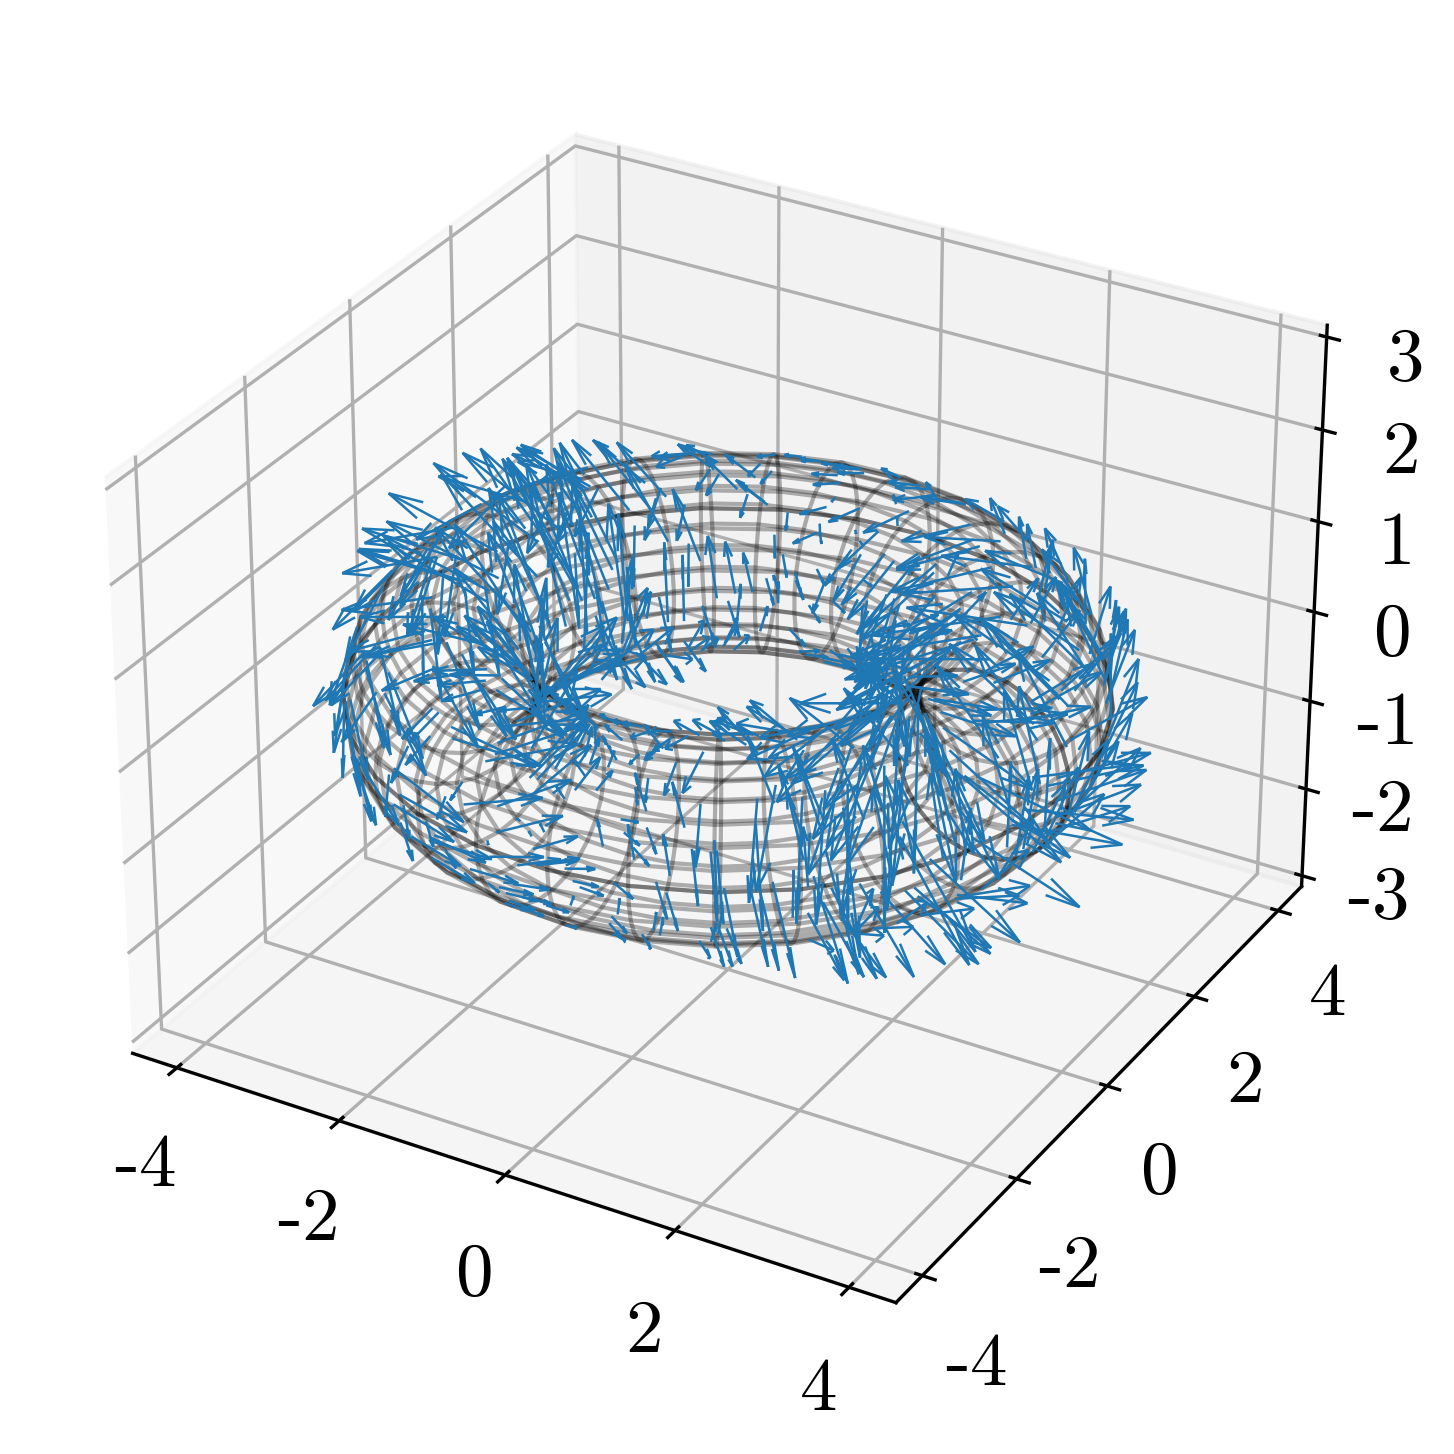

In [149]:
fig

In [120]:
#fig.savefig(f'../figures/KillingField_Torus_first.png')    
#fig.savefig(f'../figures/KillingField_Torus_first.pdf')